In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/curlew-sound-3.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/cricket-sounds-for-sleep-48.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/sparrow-sound-effect-39.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/crow-cawing-sound-effect-9.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/cricket-sounds-for-sleep-5.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/rain-thunder-and-crickets-sound-effect-4.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/crickets-chirping-crickets-sound-0.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/cricket-sounds-for-sleep-29.wav
/kaggle/input/z

# LOADING NECESSARY LIBRARIES

In [2]:
import os
import tensorflow as tf
import tensorflow_io as tfio
import keras
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

E0000 00:00:1723375760.218951      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D0811 11:29:20.226995458      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0811 11:29:20.227008804      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0811 11:29:20.227012158      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0811 11:29:20.227014638      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0811 11:29:20.227017104      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

In [3]:
forest_rec_folder="/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing"
capuchin_folder="/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips"
non_capuchin_folder="/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips"
CAPUCHIN_FILE=os.path.join(forest_rec_folder,capuchin_folder,"/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC114132-0.wav")
NON_CAPUCHIN_FILE=os.path.join(forest_rec_folder,non_capuchin_folder,"/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-4.wav")

# LOADING AND DISPLAYING THE AUDIO DATA

In [4]:
def load_audio(filepath):
    audio_binary=tf.io.read_file(filepath)
    wav,sample_rate=tf.audio.decode_wav(audio_binary,desired_channels=1)
    wav=tf.squeeze(wav,axis=-1)
    sample_rate=tf.cast(sample_rate,dtype=tf.int64)
    wav=tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)
    
    return wav    

In [5]:
capuchin_audio=load_audio(CAPUCHIN_FILE)
ncapuchin_audio=load_audio(NON_CAPUCHIN_FILE)

I0000 00:00:1723375773.540876      13 service.cc:145] XLA service 0x5c537ec787c0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723375773.540924      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1723375773.540928      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1723375773.540931      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1723375773.540934      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1723375773.540937      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1723375773.540940      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1723375773.540942      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1723375773.540946      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


In [6]:
Audio(CAPUCHIN_FILE)

In [7]:
Audio(NON_CAPUCHIN_FILE)

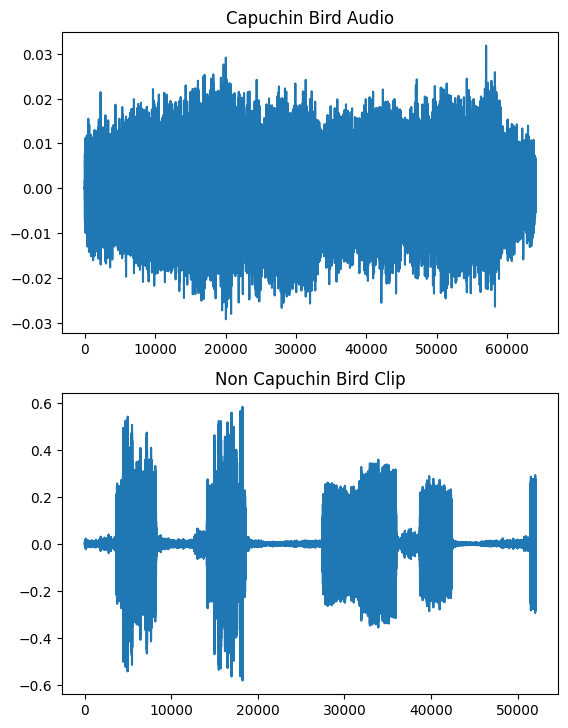

In [8]:
plt.subplot(2,1,1)
plt.plot(capuchin_audio)
plt.title("Capuchin Bird Audio")
plt.subplot(2,1,2)
plt.plot(ncapuchin_audio)
plt.title("Non Capuchin Bird Clip")
plt.subplots_adjust(bottom=-0.5)

# CREATING TENSORFLOW DATASET

In [9]:
POS=os.path.join(forest_rec_folder,capuchin_folder)
NEG=os.path.join(forest_rec_folder,non_capuchin_folder)

In [10]:
pos=tf.data.Dataset.list_files(POS+'/*.wav')
neg=tf.data.Dataset.list_files(NEG+'/*.wav')

In [11]:
positives=tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives=tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data=positives.concatenate(negatives)

In [12]:
data.shuffle(1000).as_numpy_iterator().next()

(b'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/crickets-sound-effect-7.wav',
 0.0)

In [13]:
len(data)

810

# CALCULATING LENGTH OF AUDIO CLIPS

In [14]:
lengths=[]
for file in os.listdir(os.path.join(forest_rec_folder,capuchin_folder)):
    audio_time=load_audio(os.path.join(capuchin_folder,file))
    lengths.append(len(audio_time)/16000)

Mean Length of a Capuchin Bird Call 3.4
Median Length of a Capuchin Bird Call 3.5
Maximum Length of a Capuchin Bird Call 5.0
Minimum Length of a Capuchin Bird Call 2.0


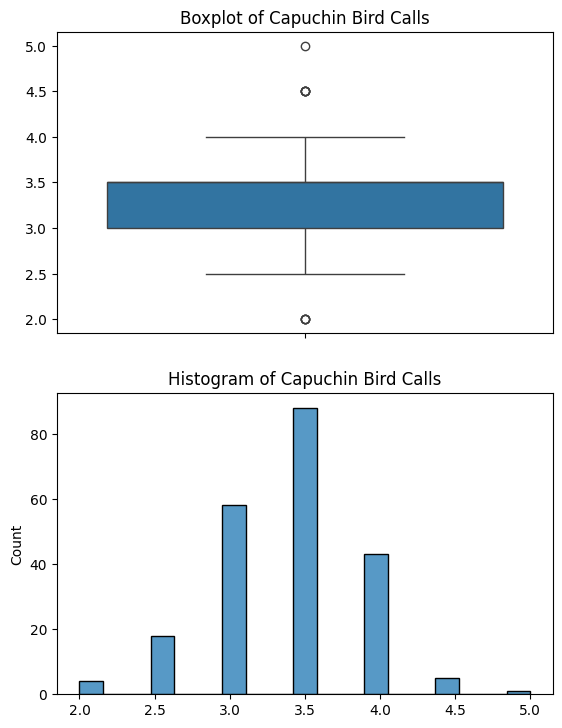

In [15]:
lengths=np.array(lengths)
print("Mean Length of a Capuchin Bird Call",np.round(lengths.mean(),1))
print("Median Length of a Capuchin Bird Call",np.median(lengths))
print("Maximum Length of a Capuchin Bird Call",lengths.max())
print("Minimum Length of a Capuchin Bird Call",lengths.min())
plt.subplot(2,1,1)
sns.boxplot(lengths)
plt.title("Boxplot of Capuchin Bird Calls")
plt.subplot(2,1,2)
sns.histplot(lengths)
plt.title("Histogram of Capuchin Bird Calls")
plt.subplots_adjust(bottom=-0.5)


# SPECTROGRAM VISUALIZATION FOR CNN MODEL

In [16]:
def spectrogram(filepath,label):

    wav=load_audio(filepath)
    wav=wav[:56000]
    padding=tf.zeros([56000]-tf.shape(wav),dtype=tf.float32)
    wav=tf.concat([padding,wav],0)
    spectrogram=tf.signal.stft(wav,frame_length=320,frame_step=32)
    spectrogram=tf.abs(spectrogram)
    spectrogram=tf.expand_dims(spectrogram,2)
    return spectrogram,label

In [17]:
filepath,label=positives.shuffle(100).as_numpy_iterator().next()
spectrogram_pos,label=spectrogram(filepath,label)

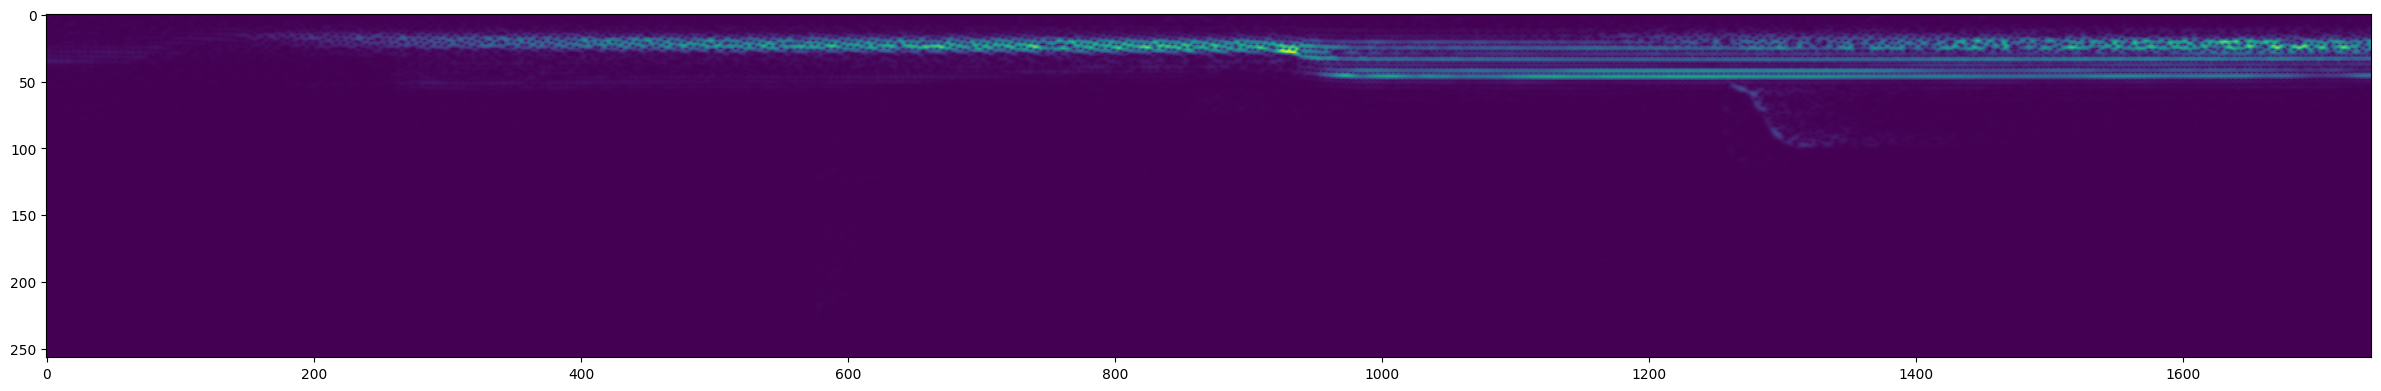

In [18]:
plt.figure(figsize=(30,30))
plt.imshow(tf.transpose(spectrogram_pos[:,:,0]))
plt.show()

In [19]:
filepath,label=negatives.shuffle(100).as_numpy_iterator().next()
spectrogram_neg,label=spectrogram(filepath,label)

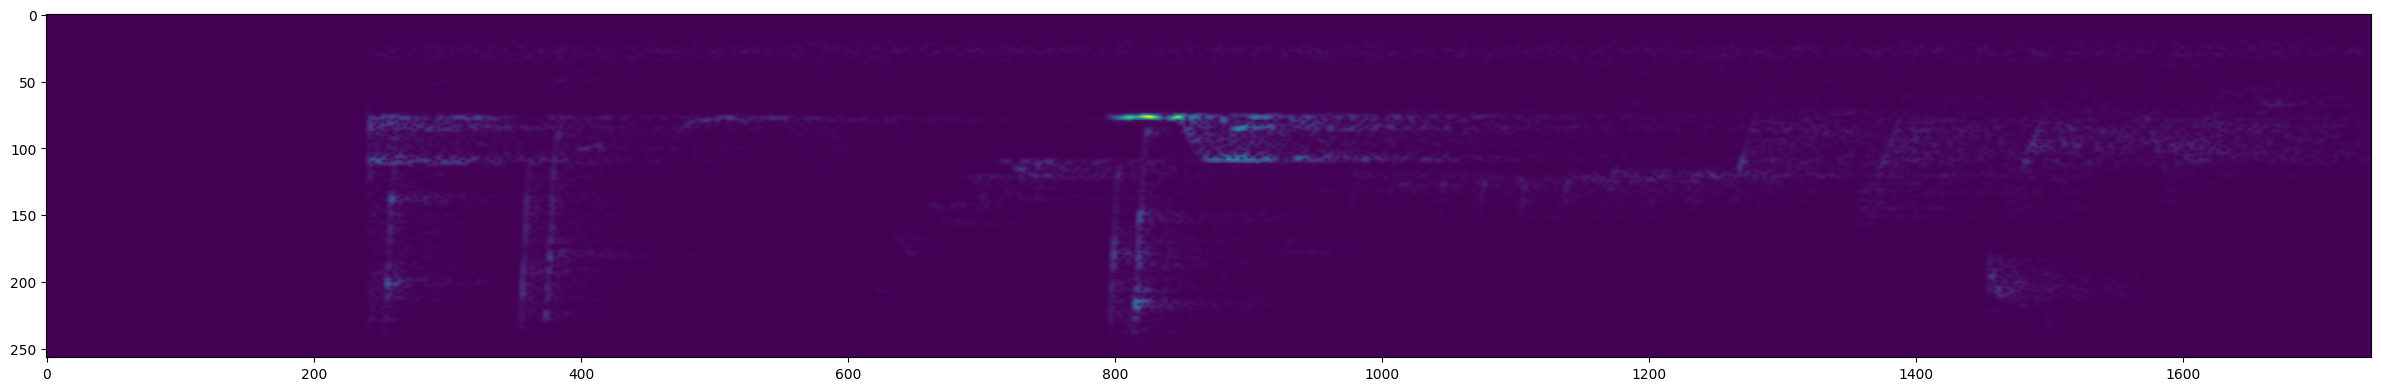

In [20]:
plt.figure(figsize=(30,30))
plt.imshow(tf.transpose(spectrogram_neg[:,:,0]))
plt.show()

In [21]:
data=data.map(spectrogram)
data=data.cache()
data=data.shuffle(buffer_size=1000)
data=data.batch(10)
data=data.prefetch(8)

In [22]:
train=data.take(36)
test=data.skip(36).take(15)

In [23]:
samples,labels=train.as_numpy_iterator().next()
samples.shape
set(labels)

{0.0, 1.0}

# CNN MODEL DEVELOPMENT

In [24]:
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Flatten
from tensorflow.keras.metrics import Precision, Recall
model=Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(1741,257,1)))
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1739, 255, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1737, 253, 16)  │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7031376)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   900,016,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 900,018,865 (3.35 GB)

 Trainable params: 900,018,865 (3.35 GB)

 Non-trainable params: 0 (0.00 B)

In [30]:
for x_batch, y_batch in train.take(36):
    if x_batch is None or y_batch is None:
        print("Found None in the dataset")

In [31]:
tf.debugging.assert_shapes([
    (x_batch, ('batch', 'height', 'width', 'channels')),
    (y_batch, ('batch',))
], message="Shapes don't match!")

In [32]:
tf.config.run_functions_eagerly(True)

In [29]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 344s 10s/step - loss: 25.5516 - precision: 0.6445 - recall: 0.7602 - val_loss: 0.2353 - val_precision: 0.9286 - val_recall: 1.0000
Epoch 2/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 347s 10s/step - loss: 0.0666 - precision: 0.9854 - recall: 0.9722 - val_loss: 0.0837 - val_precision: 0.9535 - val_recall: 1.0000
Epoch 3/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 347s 10s/step - loss: 0.0448 - precision: 0.9558 - recall: 0.9925 - val_loss: 0.0032 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 349s 10s/step - loss: 0.0049 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.7106e-04 - val_precision: 1.0000 - val_recall: 1.0000


# PLOTTING KPI'S

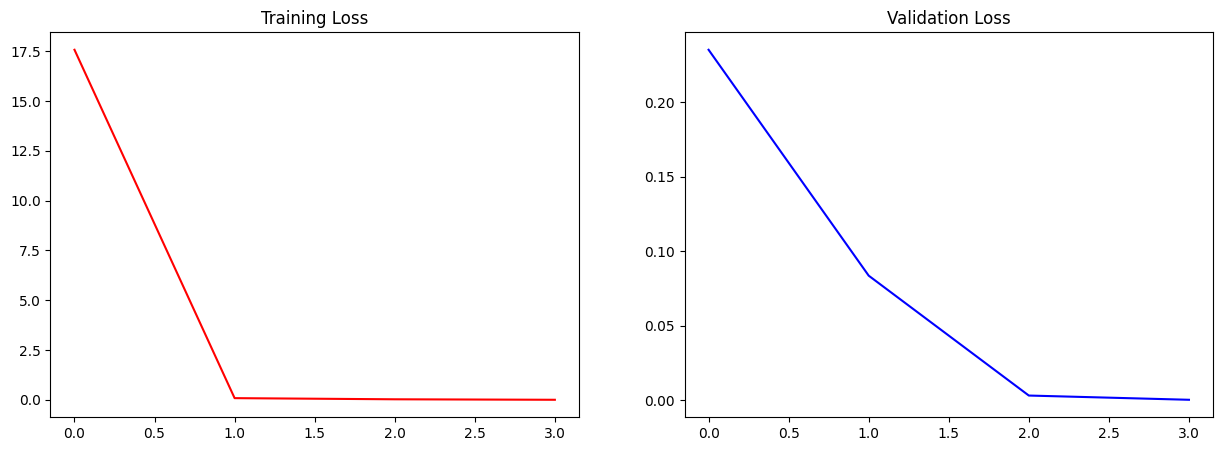

In [47]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Training Loss")
plt.plot(hist.history['loss'],'r')
plt.subplot(1,2,2)
plt.title("Validation Loss")
plt.plot(hist.history['val_loss'],'b')

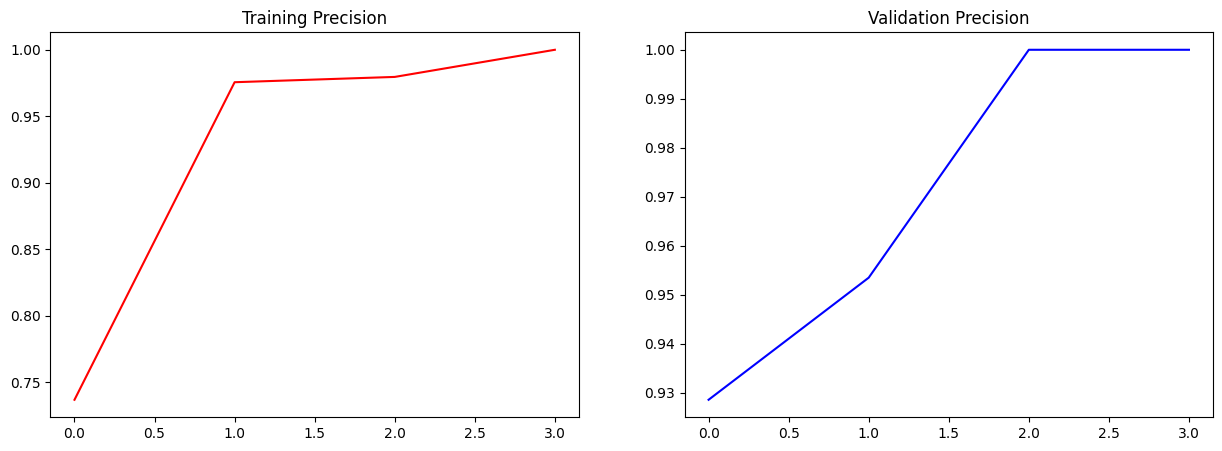

In [45]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Training Precision")
plt.plot(hist.history['precision'],'r')
plt.subplot(1,2,2)
plt.title("Validation Precision")
plt.plot(hist.history['val_precision'],'b')

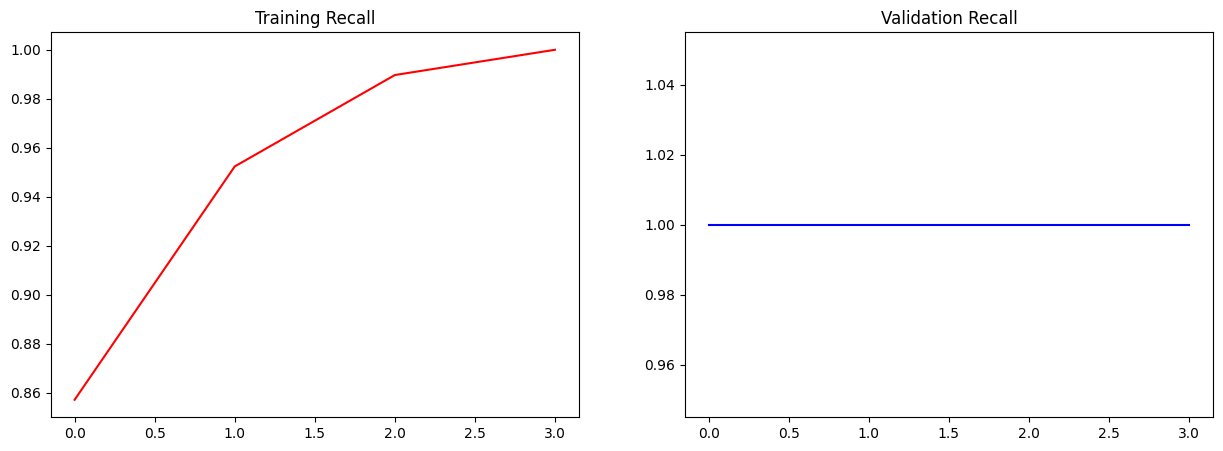

In [46]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Training Recall")
plt.plot(hist.history['recall'],'r')
plt.subplot(1,2,2)
plt.title("Validation Recall")
plt.plot(hist.history['val_recall'],'b')

# TESTING ON ONE FOREST RECORDING

In [66]:
X_test,y_test=test.as_numpy_iterator().next()
y_pred=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


In [67]:
y_pred=[1 if prediction>0.99 else 0 for prediction in y_pred]

In [70]:
tf.math.reduce_sum(y_pred)

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [71]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=3.0>

In [95]:
def load_mp3_forest(filepath):
    forest_rec=tfio.audio.AudioIOTensor(filepath)
    rec=forest_rec.to_tensor()
    rec=tf.math.reduce_sum(rec,axis=1)/2
    sample_rate=forest_rec.rate
    sample_rate=tf.cast(sample_rate,dtype=tf.int64)
    wav=tfio.audio.resample(rec,rate_in=sample_rate,rate_out=16000)
    return wav

In [96]:
mp3=os.path.join(forest_rec_folder,"/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings","/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings/recording_02.mp3")

In [97]:
wav=load_mp3_forest(mp3)

In [109]:
wav

<tf.Tensor: shape=(2880666,), dtype=float32, numpy=
array([ 2.6820102e-10, -6.0825595e-10,  1.1104190e-09, ...,
       -3.8720197e-03,  1.0911611e-02,  5.8019273e-03], dtype=float32)>

In [99]:
Audio(mp3)

Text(0.5, 1.0, 'Forest Recording')

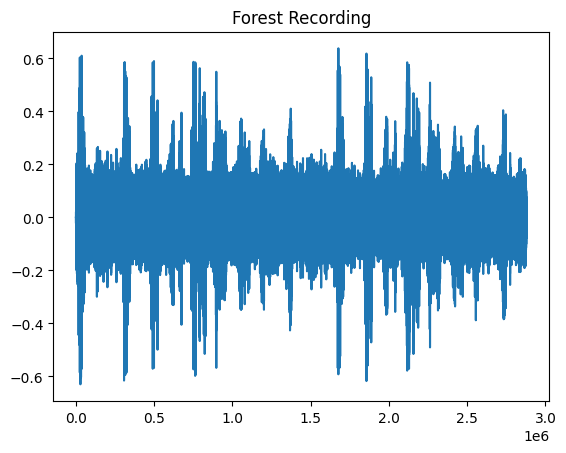

In [103]:
plt.plot(wav)
plt.title("Forest Recording")

# AUDIO SLICING FOR SLIDING MODEL APPROACH

In [130]:
audio_slices=tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=56000,sequence_stride=56000,batch_size=1)

In [131]:
samples,index=audio_slices.as_numpy_iterator().next()
samples.shape

(1, 56000)

In [132]:
len(audio_slices)

51

In [133]:
def spectrogram_mp3(sample,index):

    sample=sample[0]
    padding=tf.zeros([56000]-tf.shape(sample),dtype=tf.float32)
    wav=tf.concat([padding,sample],0)
    spectrogram=tf.signal.stft(wav,frame_length=320,frame_step=32)
    spectrogram=tf.abs(spectrogram)
    spectrogram=tf.expand_dims(spectrogram,2)
    return spectrogram

In [134]:
audio_slices=tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=56000,sequence_stride=56000,batch_size=1)
audio_slices=audio_slices.map(spectrogram_mp3)
audio_slices=audio_slices.batch(64)

# PREDICTION AND COUNTING CAPUCHIN BIRD CALLS 

In [135]:
y_pred=model.predict(audio_slices)
y_pred=[1 if prediction>0.99 else 0 for prediction in y_pred]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [128]:
len(y_pred)

51

In [137]:
from itertools import groupby
y_pred=[key for key,group in groupby(y_pred)]

In [140]:
tf.math.reduce_sum(y_pred).numpy()

0

In [141]:
results={}
for file in os.listdir(os.path.join(forest_rec_folder,"/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings")):
    filepath=os.path.join(forest_rec_folder,"/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings",file)
    wav=load_mp3_forest(filepath)
    audio_slices=tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=56000,sequence_stride=56000,batch_size=1)
    audio_slices=audio_slices.map(spectrogram_mp3)
    audio_slices=audio_slices.batch(64)
    y_pred=model.predict(audio_slices)
    results[file]=y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [146]:
rec_pred={}
for file,logits in results.items():
    rec_pred[file]=[1 if prediction>0.99 else 0 for prediction in logits]


In [155]:
final_score={}
for file,pred in rec_pred.items():
    final_score[file]=tf.math.reduce_sum([key for key,group in groupby(pred)]).numpy()
final_score

{'recording_76.mp3': 1,
 'recording_62.mp3': 8,
 'recording_48.mp3': 4,
 'recording_44.mp3': 1,
 'recording_45.mp3': 3,
 'recording_06.mp3': 7,
 'recording_43.mp3': 5,
 'recording_68.mp3': 1,
 'recording_95.mp3': 6,
 'recording_17.mp3': 1,
 'recording_65.mp3': 5,
 'recording_74.mp3': 5,
 'recording_10.mp3': 5,
 'recording_49.mp3': 0,
 'recording_15.mp3': 2,
 'recording_37.mp3': 5,
 'recording_64.mp3': 5,
 'recording_39.mp3': 1,
 'recording_04.mp3': 6,
 'recording_28.mp3': 1,
 'recording_05.mp3': 0,
 'recording_80.mp3': 1,
 'recording_57.mp3': 6,
 'recording_12.mp3': 1,
 'recording_59.mp3': 1,
 'recording_67.mp3': 0,
 'recording_09.mp3': 0,
 'recording_79.mp3': 0,
 'recording_14.mp3': 0,
 'recording_63.mp3': 1,
 'recording_86.mp3': 1,
 'recording_47.mp3': 1,
 'recording_03.mp3': 0,
 'recording_33.mp3': 0,
 'recording_08.mp3': 8,
 'recording_51.mp3': 2,
 'recording_35.mp3': 0,
 'recording_81.mp3': 5,
 'recording_30.mp3': 4,
 'recording_88.mp3': 0,
 'recording_75.mp3': 1,
 'recording_46.m

# STORING THE FINAL COUNTS IN A CSV FILE

In [154]:
import csv
with open('capuchin_results.csv','w',newline='') as f:
    writer=csv.writer(f,delimiter=',')
    writer.writerow(['recording','no_of_capuchin_calls'])
    for key,value in final_score.items():
        writer.writerow([key,value])
                     
    
        